In [1]:
# %%
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from src.utils.load_dataframe import load_time_series_60min


In [2]:
# Check if GPU is available
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    # Activate GPU by default
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15257339495107022905
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 3986336186523821348
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]
Default GPU Device: /device:GPU:0


2024-09-14 13:23:54.741121: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-14 13:23:54.741142: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-09-14 13:23:54.741148: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-09-14 13:23:54.741321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-14 13:23:54.741333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-14 13:23:54.743782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been bui

In [3]:
# 1. Load data
df = load_time_series_60min()


In [4]:
# Select the target column for energy demand in Germany
target_column = 'DE_load_actual_entsoe_transparency'
y = df[target_column].values

In [5]:
# Predict using only the target column
X = y

In [6]:
# Ensure no null values
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]


In [7]:
# 2. Scale the data using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1))

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [8]:
# Function to create time sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
# Define the time sequence length
seq_length = 60

In [10]:
# Create sequences from scaled X and y
X_seq, y_seq = create_sequences(X_scaled, seq_length)
y_seq = y_seq.reshape(-1, 1)


In [11]:
# Reshape X to be compatible with CNN input
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [12]:
# 3. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [13]:
# 4. Create CNN model with improvements
model = Sequential()

# First convolution and max pooling layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Second convolution and max pooling layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add flatten and dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-14 13:23:55.900198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-14 13:23:55.900222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# 5. Compile the model using Adam optimizer
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [15]:
# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [16]:
# 6. Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increase epochs to improve accuracy
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20


2024-09-14 13:23:56.440504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0177 - val_loss: 0.0034
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 7/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0021 - val_loss: 9.1314e-04
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0020 - val_loss: 9.3478e-04
Epoch 12/20
1259/1259 ━

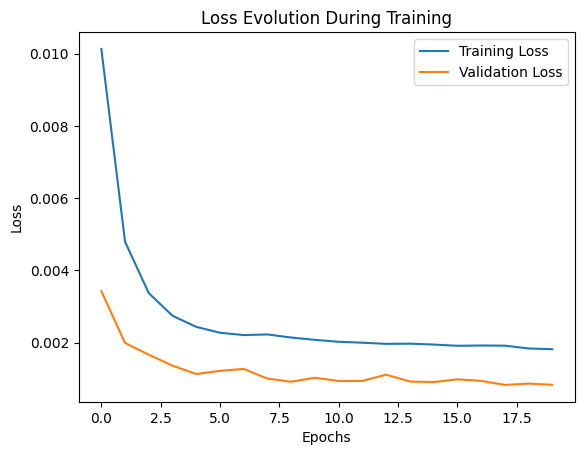

In [17]:
# 7. Plot the loss evolution during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# 8. Make predictions and inverse scale the results
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [35]:
import importlib
import src.utils.conclusion_metrics
importlib.reload(src.utils.conclusion_metrics)
from src.utils.conclusion_metrics import calculate_all_metrics
# 9. Evaluate model performance
calculate_all_metrics(y_test, y_pred)

MSE: 1764773.3467454957
RMSE: 1328.4477207423315
MAE: 991.8172010407355
R2: 0.9817697081123729
MAPE: 1.9180080897486431%
Accuracy: 93.95113230035757% with a tolerance of 5%


(1764773.3467454957,
 1328.4477207423315,
 991.8172010407355,
 0.9817697081123729,
 1.9180080897486431,
 93.95113230035757)

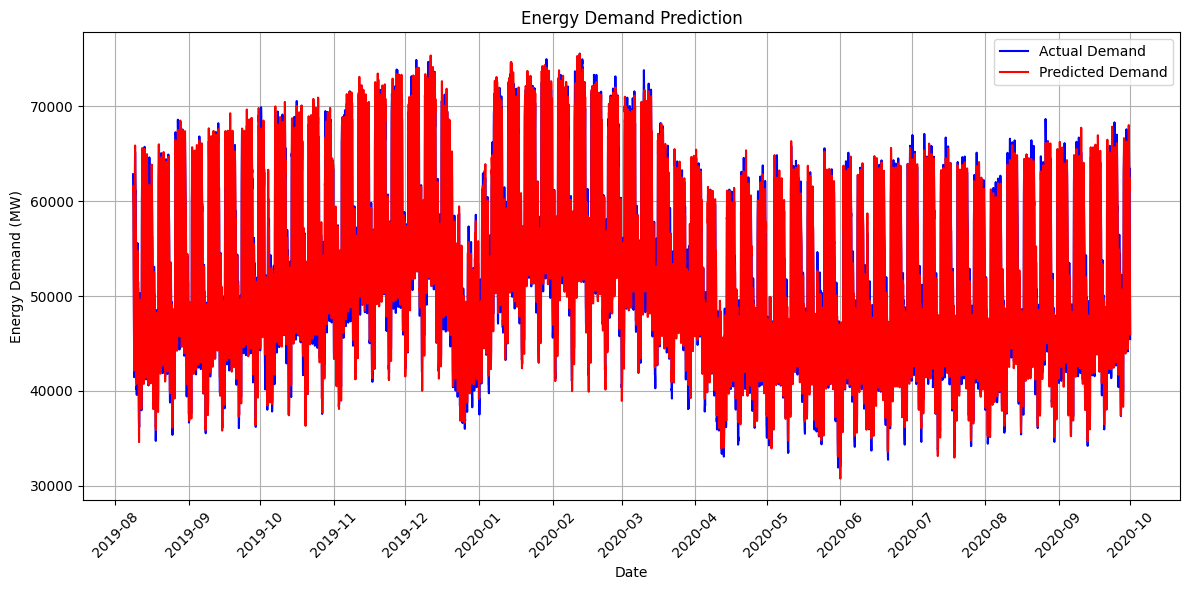

In [30]:
# 10. Plot results with proper dates on the X-axis
plt.figure(figsize=(12, 6))

# Assign the dates to the X-axis, assuming the index of df_test contains the dates
test_dates = df.index[-len(y_test):]  # Extract the dates corresponding to y_test

plt.plot(test_dates, y_test, color='blue', label='Actual Demand')
plt.plot(test_dates, y_pred, color='red', label='Predicted Demand')

plt.title('Energy Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Demand (MW)')
plt.legend()

# Format the X-axis to properly show the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# 12. Improve monthly predictions for 2020
df.index = pd.to_datetime(df.index, utc=True)  # Index is already 'utc_timestamp' after parsing
df_2020 = df[df.index.year == 2020]  # Filter by the year 2020
print(f"Size of 2020 data: {len(df_2020)} rows")
y_2020 = df_2020[target_column].values
y_2020_scaled = scaler_y.transform(y_2020.reshape(-1, 1))


Size of 2020 data: 6576 rows


In [22]:
# Create sequences and make predictions for 2020
X_2020_seq, _ = create_sequences(y_2020_scaled, seq_length)
X_2020_seq = np.reshape(X_2020_seq, (X_2020_seq.shape[0], X_2020_seq.shape[1], 1))
predictions_2020_scaled = model.predict(X_2020_seq)
predictions_2020 = scaler_y.inverse_transform(predictions_2020_scaled)

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [23]:
# Create a DataFrame with predictions and dates
predictions_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020.index[seq_length:],  # Since 'utc_timestamp' is now the index
    'predictions': predictions_2020.flatten()
})

In [24]:
# Aggregate by month for monthly predictions
monthly_predictions_2020 = predictions_2020_df.resample('ME', on='utc_timestamp').sum()


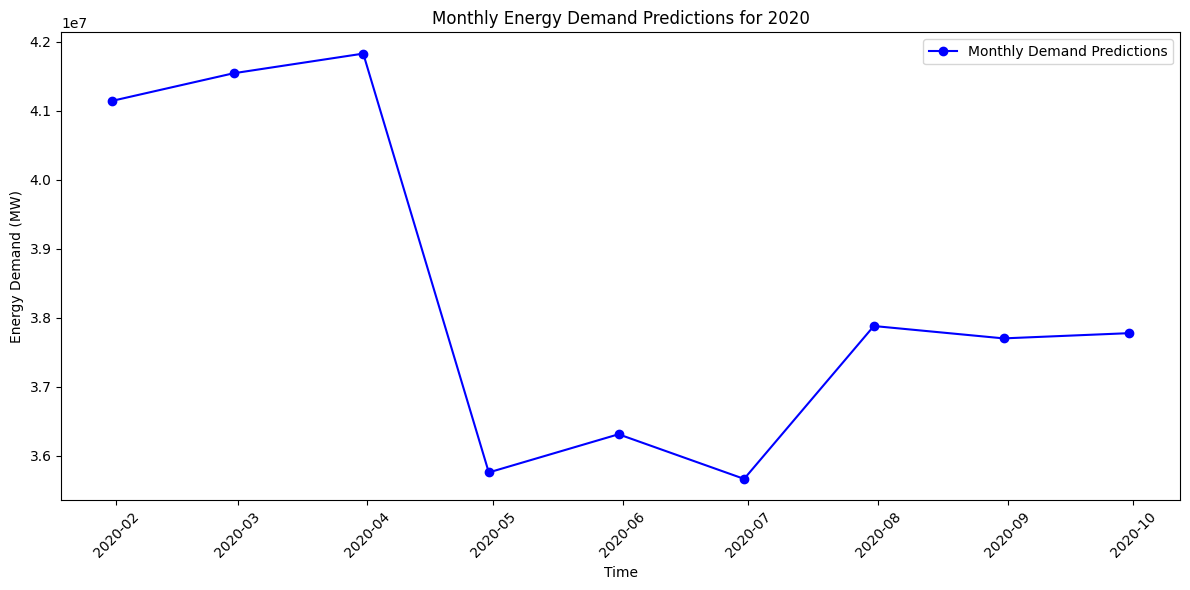

In [25]:
# Plot monthly predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_2020.index, monthly_predictions_2020['predictions'], color='blue', marker='o', label='Monthly Demand Predictions')
plt.title('Monthly Energy Demand Predictions for 2020')
plt.xlabel('Time')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# 11. Compare monthly predictions with actual demand

# Real demand for 2020
real_demand_2020 = df_2020[target_column].values[seq_length:]

In [27]:
# Real demand for 2020
# Create a DataFrame for real monthly demand
real_demand_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020.index[seq_length:],  # Since 'utc_timestamp' is now the index
    'real_demand': real_demand_2020
})

In [28]:
# Aggregate real demand by month
real_monthly_demand_2020 = real_demand_2020_df.resample('ME', on='utc_timestamp').sum()

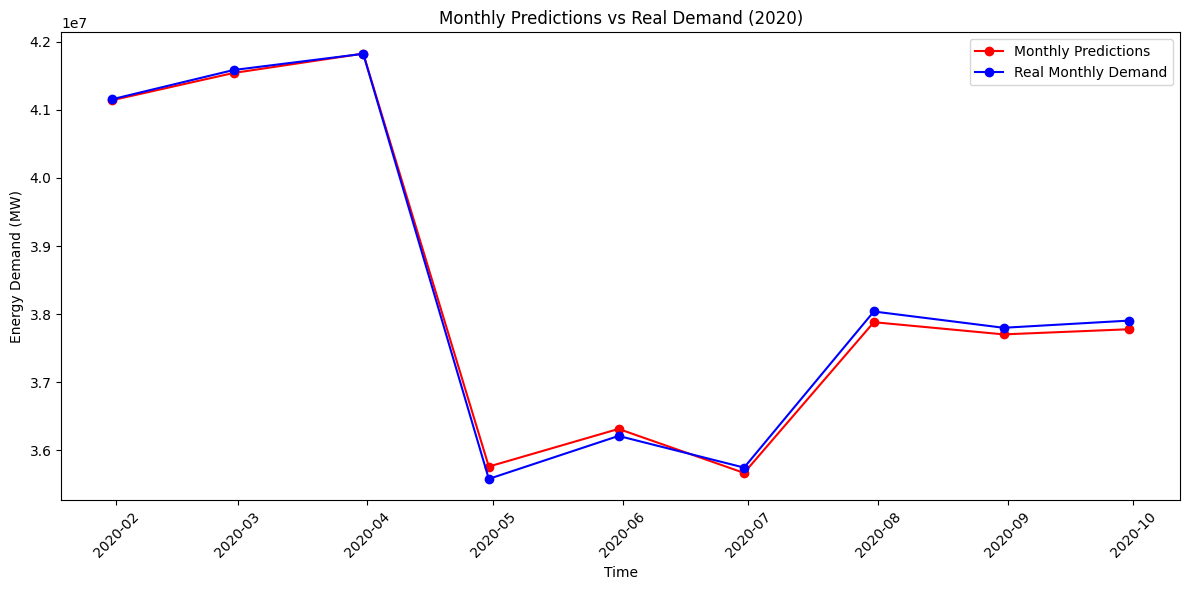

In [29]:
# Plot predictions vs real demand
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_2020.index, monthly_predictions_2020['predictions'], color='red', marker='o', label='Monthly Predictions')
plt.plot(real_monthly_demand_2020.index, real_monthly_demand_2020['real_demand'], color='blue', marker='o', label='Real Monthly Demand')
plt.title('Monthly Predictions vs Real Demand (2020)')
plt.xlabel('Time')
plt.ylabel('Energy Demand (MW)')
plt.legend()
# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()